# Predicting Stock Movements by Analyzing News Data

## Importing Packages

In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk

from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pd.set_option('display.max_columns', None)

## Preparing the News Data

In [2]:
df_news = pd.read_csv('data/market_data.csv')
df_news.info()

C:\Users\nicol\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 823480 entries, 0 to 823479
Data columns (total 48 columns):
TIMESTAMP_UTC           823480 non-null object
RPNA_DATE_UTC           823480 non-null object
RPNA_TIME_UTC           823480 non-null object
RP_ENTITY_ID            823480 non-null object
ENTITY_TYPE             823480 non-null object
ENTITY_NAME             823480 non-null object
POSITION_NAME           5568 non-null object
RP_POSITION_ID          5568 non-null object
COUNTRY_CODE            823480 non-null object
RELEVANCE               823480 non-null int64
TOPIC                   45300 non-null object
GROUP                   45300 non-null object
TYPE                    45300 non-null object
SUB_TYPE                21440 non-null object
PROPERTY                14679 non-null object
EVALUATION_METHOD       0 non-null float64
MATURITY                0 non-null float64
CATEGORY                45300 non-null object
ESS                     45300 non-null float64
AES            

In [3]:
# change formats
df_news['TICKER'] = df_news['COMPANY'].str[3:]
df_news['TIMESTAMP_UTC'] = pd.to_datetime(df_news['TIMESTAMP_UTC'], utc = True)
df_news['RPNA_DATE_UTC'] = df_news['TIMESTAMP_UTC'].dt.date
df_news['RPNA_TIME_UTC'] = df_news['TIMESTAMP_UTC'].dt.time

In [4]:
# get Eastern Standard Time
df_news['TIMESTAMP_EST'] = df_news['TIMESTAMP_UTC'].dt.tz_convert('America/New_York')
df_news['RPNA_DATE_EST'] = df_news['TIMESTAMP_EST'].dt.date
df_news['RPNA_TIME_EST'] = df_news['TIMESTAMP_EST'].dt.time

In [5]:
# if market is closed get next day
from pandas.tseries.offsets import CustomBusinessDay

from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday, nearest_workday, \
    USMartinLutherKingJr, USPresidentsDay, GoodFriday, USMemorialDay, \
    USLaborDay, USThanksgivingDay

class USTradingCalendar(AbstractHolidayCalendar):
    rules = [Holiday('NewYearsDay', month = 1, day = 1, observance = nearest_workday),
             USMartinLutherKingJr,
             USPresidentsDay,
             GoodFriday,
             USMemorialDay,
             Holiday('USIndependenceDay', month = 7, day = 4, observance = nearest_workday),
             USLaborDay,
             USThanksgivingDay,
             Holiday('Christmas', month = 12, day = 25, observance = nearest_workday)]

bday_us = CustomBusinessDay(calendar = USTradingCalendar())

nasdaq_close = pd.to_datetime('16:00:00').time()

df_news['NEXT_MARKET_DATE'] = pd.to_datetime(np.where(df_news['RPNA_TIME_EST'] > nasdaq_close,
                                                      df_news['RPNA_DATE_EST'] + bday_us,
                                                      df_news['RPNA_DATE_EST'] + 0 * bday_us))
df_news['NEXT_MARKET_CLOSE'] = (df_news['NEXT_MARKET_DATE'] + pd.Timedelta(16, unit ='h')).dt.tz_localize('America/New_York')
df_news['TIME_TO_CLOSE'] = df_news['NEXT_MARKET_CLOSE'] - df_news['TIMESTAMP_EST']

## Preparing the Market Data

In [6]:
df_market = pd.read_csv('data/nasdaq.csv')
df_market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28248 entries, 0 to 28247
Data columns (total 12 columns):
gvkey       28248 non-null int64
iid         28248 non-null int64
datadate    28248 non-null object
tic         28248 non-null object
conm        28248 non-null object
cshtrd      28221 non-null float64
prccd       28221 non-null float64
prchd       28221 non-null float64
prcld       28221 non-null float64
prcod       27876 non-null float64
trfd        28222 non-null float64
exchg       28248 non-null int64
dtypes: float64(6), int64(3), object(3)
memory usage: 2.6+ MB


In [7]:
# change formats
df_market['datadate'] = pd.to_datetime(df_market['datadate'],
                                       dayfirst = True)

In [8]:
# compute stock return and volatility
df_market['dreturn'] = np.log(df_market.prccd / df_market.prcod)
df_market['dvar'] = ((np.log(df_market.prchd) - np.log(df_market.prcld))**2) / 4 * np.log(2) #Applying the Parkinson (1980) H-L measure
df_market['dvol'] = np.sqrt(df_market.dvar)
df_market['dreturn_flag'] = np.where(df_market['dreturn'] > 0, 1, 0)

## Joining News and Market Data

In [9]:
df = pd.merge(df_news, df_market, how = 'left',
              left_on = ['NEXT_MARKET_DATE', 'TICKER'],
              right_on = ['datadate', 'tic'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 823480 entries, 0 to 823479
Data columns (total 71 columns):
TIMESTAMP_UTC           823480 non-null datetime64[ns, UTC]
RPNA_DATE_UTC           823480 non-null object
RPNA_TIME_UTC           823480 non-null object
RP_ENTITY_ID            823480 non-null object
ENTITY_TYPE             823480 non-null object
ENTITY_NAME             823480 non-null object
POSITION_NAME           5568 non-null object
RP_POSITION_ID          5568 non-null object
COUNTRY_CODE            823480 non-null object
RELEVANCE               823480 non-null int64
TOPIC                   45300 non-null object
GROUP                   45300 non-null object
TYPE                    45300 non-null object
SUB_TYPE                21440 non-null object
PROPERTY                14679 non-null object
EVALUATION_METHOD       0 non-null float64
MATURITY                0 non-null float64
CATEGORY                45300 non-null object
ESS                     45300 non-null float64
AE

## Data Cleaning

In [10]:
# drop columns with no explanatory worth
drop = ['TIMESTAMP_UTC', 'RPNA_DATE_UTC', 'RPNA_TIME_UTC', 'RP_ENTITY_ID',
        'ENTITY_TYPE', 'ENTITY_NAME', 'RP_POSITION_ID', 'COUNTRY_CODE',
        'EVALUATION_METHOD', 'ENS_KEY', 'G_ENS_KEY', 'EVENT_SIMILARITY_KEY',
        'RP_STORY_ID', 'PRODUCT_KEY', 'COMPANY', 'ISIN', 'BER', 'ANL_CHG',
        'TICKER', 'NEXT_MARKET_DATE', 'NEXT_MARKET_CLOSE', 'gvkey', 'iid', 'datadate', 'tic',
        'conm', 'cshtrd', 'prccd', 'prchd', 'prcld', 'prcod', 'trfd', 'exchg']
df = df.drop(drop, axis = 1)

In [11]:
# show missing data in rows
missing = (df.isnull().sum(axis = 1) / df.isnull().count(axis = 1)).sort_values(ascending = False)
missing_rows = pd.concat([missing], axis = 1, keys = ['Missing'])
drop_rows = missing_rows[missing_rows['Missing'] > 0.25]
drop_rows.count()

Missing    778180
dtype: int64

In [12]:
# drop observations where most features are missing
df = df.drop(drop_rows.index, axis = 0)

In [13]:
# show missing data in columns
total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum() / df.isnull().count()).sort_values(ascending = False)
missing_clmns = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
missing_clmns.head(5)

,Total,Percent
MATURITY,45300,1.000000
POSITION_NAME,39732,0.877086
PROPERTY,30621,0.675960
SUB_TYPE,23860,0.526711
dvol,2754,0.060795


In [14]:
# drop features where most observations are missing
df = df.drop((missing_clmns[missing_clmns['Percent'] > 0.25]).index, axis = 1)

In [15]:
# check if missing values remain
df.isnull().sum().max()

2754

## Data Exploration

C:\Users\nicol\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\nicol\Anaconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)
C:\Users\nicol\Anaconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)


ValueError: cannot convert float NaN to integer

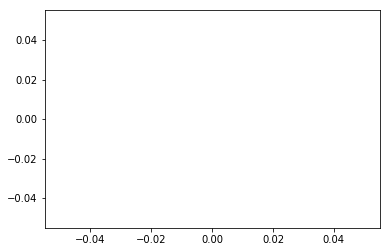

In [16]:
sns.distplot(df['dreturn']);

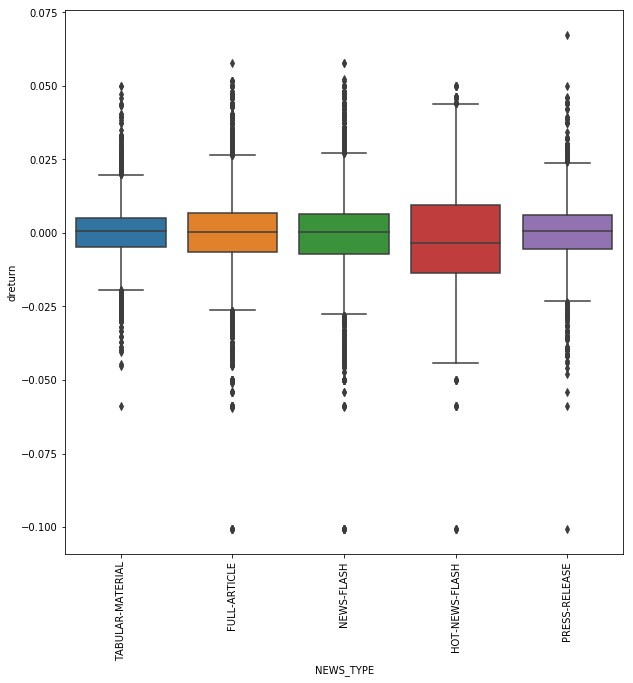

In [17]:
var_x = 'NEWS_TYPE'
var_y = 'dreturn'
data = pd.concat([df[var_x], df[var_y]], axis = 1)
plt.subplots(figsize = (10, 10))
fig = sns.boxplot(x = var_x, y = var_y, data = data)
plt.xticks(rotation = 90);

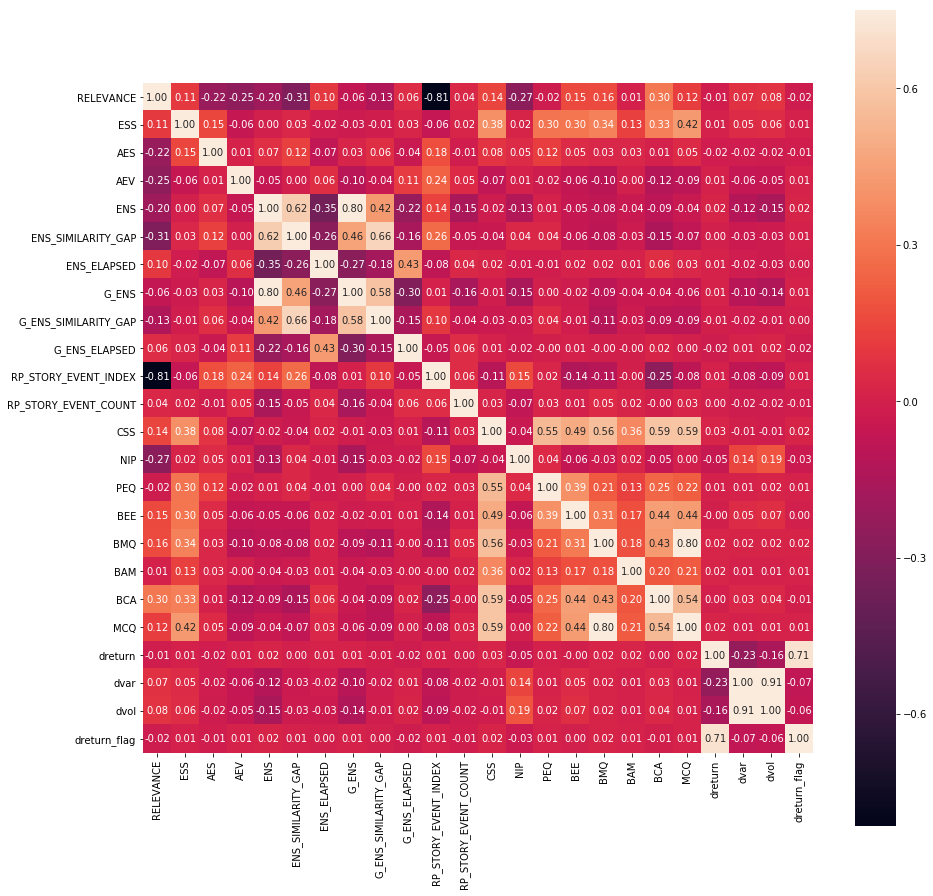

In [18]:
# check correlation of all variables
corrmat = df.corr()
plt.subplots(figsize = (15, 15))
sns.heatmap(corrmat, vmax = 0.75, square = True, annot = True, fmt='.2f');

C:\Users\nicol\Anaconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\nicol\Anaconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


ValueError: max must be larger than min in range parameter.

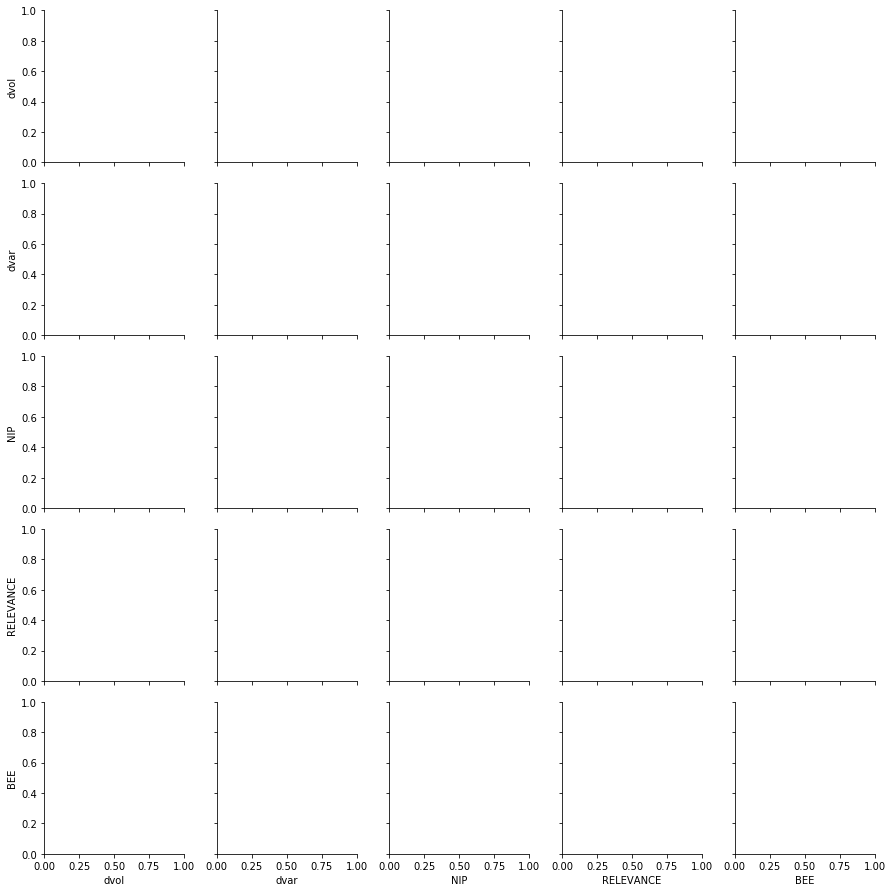

In [19]:
# visualize relationship between the most correlated variables
cols = corrmat.nlargest(5, 'dvol')['dvol'].index
sns.pairplot(df[cols])
plt.show()

In [ ]:
# transform nominal features to dummy features
# df = pd.get_dummies(df)

## Model Selection

In [20]:
# split the dataset into training data and test data
X = df[['ESS', 'G_ENS']]
Y = df['dvol']
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, random_state = 0)

In [21]:
lr = LogisticRegression()
lr.fit(X_train, Y_train)
lr.predict(X_test)
lr.score(X_train, Y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').